In [60]:
from imports import *
from datasets.idd import *
from plotting import *
import pickle

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [65]:
labels = {'person':0,'rider':1,'car':2,'truck':3,
         'bus':4,'motorcycle':5,'bicycle':6,'autorickshaw':7,'animal':8,'traffic light':9,
          'traffic sign':10,'vehicle fallback':11,'caravan':12,'trailer':13,'train':14}

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features,num_classes)
    return model.cuda()

In [11]:
model = get_model(len(labels))
#model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)



In [12]:
checkpoint = torch.load('saved_models/sideRight.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

In [13]:
test_paths = []
with open('/ml/temp/autonue/data/IDD_Detection/test.txt') as f:
    test_paths = f.readlines()

In [14]:
for i in range(len(test_paths)):
    test_paths[i] = test_paths[i].strip('\n')
    test_paths[i] = test_paths[i]+'.jpg'
    test_paths[i] = os.path.join('/ml/temp/autonue/data/IDD_Detection/JPEGImages',test_paths[i])

In [15]:
model.eval();

In [16]:
model.cpu();

In [100]:
im0 = Image.open(test_paths[321])
im0_tensor = torchvision.transforms.ToTensor()(im0);
pred = model([im0_tensor])

In [101]:
total_preds = []
for n,confidence in enumerate(pred[0]['scores']):
    if confidence>0.75:
        pred_update = {}
        pred_update['boxes'] = pred[0]['boxes'][n]
        pred_update['labels'] = pred[0]['labels'][n]
        pred_update['scores'] = pred[0]['scores'][n]
        total_preds.append(pred_update)

In [102]:
total_preds

[{'boxes': tensor([647.8467, 435.8778, 802.7087, 546.0433], grad_fn=<SelectBackward>),
  'labels': tensor(11),
  'scores': tensor(0.9969, grad_fn=<SelectBackward>)}]

In [89]:
#labels = {k:v for v,k in labels.items()}

In [90]:
def plot_from_image_preds(img,total_preds):
    #im = np.array(Image.open(img), dtype=np.uint8)
    fig,ax = plt.subplots(1)
    #ax.imshow(img)
    for i in range(len(total_preds)):
        xy = total_preds[i]['boxes'][0],total_preds[i]['boxes'][1]
        width = total_preds[i]['boxes'][2]-total_preds[i]['boxes'][0]
        height = total_preds[i]['boxes'][3]-total_preds[i]['boxes'][1]
        rect = patches.Rectangle(xy,width,height,linewidth=1,edgecolor='r',facecolor='none')
        ax.text(xy[0],xy[1],labels[total_preds[i]['labels'].item()])
        ax.add_patch(rect)
    ax.imshow(img)

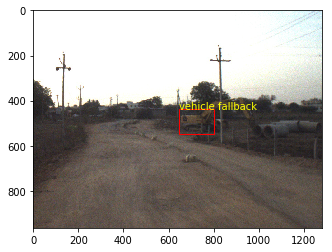

In [103]:
plot_from_image_preds(im0,total_preds)

In [20]:
## computing iou
val_img_paths = []
with open('/ml/temp/autonue/data/IDD_Detection/val.txt') as f:
    val_img_paths = f.readlines()
for i in range(len(val_img_paths)):
    val_img_paths[i] = val_img_paths[i].strip('\n')
    val_img_paths[i] = val_img_paths[i]+'.jpg'
    val_img_paths[i] = os.path.join('/ml/temp/autonue/data/IDD_Detection/JPEGImages',val_img_paths[i])

In [21]:
val_anno_paths = []
for i in range(len(val_img_paths)):
    val_anno_paths.append(val_img_paths[i].replace('JPEGImages','Annotations'))
    val_anno_paths[i] = val_anno_paths[i].replace('.jpg','.xml')
val_img_paths = sorted(val_img_paths)


In [22]:
get_label_bboxes(val_anno_paths[0])

(tensor([3., 3., 3., 0., 5., 5.]), tensor([[ 401.,  392.,  619.,  488.],
         [ 638.,  381.,  835.,  497.],
         [ 733.,  379.,  928.,  493.],
         [1093.,  486., 1172.,  707.],
         [1101.,  426., 1144.,  463.],
         [1217.,  426., 1266.,  454.]]))

In [23]:
im0 = Image.open(val_img_paths[0])
im0_tensor = torchvision.transforms.ToTensor()(im0);
val_pred = model([im0_tensor])

In [24]:
val_pred

[{'boxes': tensor([[541.4008, 331.9060, 761.8844, 614.8079],
          [545.6003, 335.4401, 761.6399, 609.9041]], grad_fn=<StackBackward>),
  'labels': tensor([ 3, 11]),
  'scores': tensor([0.9953, 0.1659], grad_fn=<IndexBackward>)}]

In [26]:
from datasets.idd import *
val_dataset = IDD_Dataset(val_img_paths,val_anno_paths)

In [27]:
val_dataset[10]

(<PIL.Image.Image image mode=RGB size=1280x964 at 0x7F935B3113C8>,
 {'boxes': tensor([[578., 302., 818., 596.]]),
  'labels': tensor([3.]),
  'image_id': tensor([10.]),
  'area': tensor([70560.]),
  'iscrowd': tensor([0])})

In [76]:
val_dl =  torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4,collate_fn=utils.collate_fn)

In [64]:
import time

In [43]:
iou_types = _get_iou_types(model)
from coco_eval import CocoEvaluator

In [35]:
from coco_utils import get_coco_api_from_dataset
coco = get_coco_api_from_dataset(dl.dataset)

creating index...
index created!


In [39]:
def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

In [115]:
@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'
    model.to(device)
    #coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for image, targets in metric_logger.log_every(data_loader, 100, header):
        #print(image)
        #image = torchvision.transforms.ToTensor()(image[0])  # Returns a scaler tuple
        #print(image.shape)                                # dim of image 1080x1920
        
        image = torchvision.transforms.ToTensor()(image[0]).to(device)
        #image = list(img.to(device) for img in image)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        torch.cuda.synchronize()
        model_time = time.time()
        
        outputs = model([image.to(device)])

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

In [116]:
evaluate(model,val_dl,device="cpu")

Test:  [    0/10225]  eta: 1 day, 19:24:26  model_time: 14.4661 (14.4661)  evaluator_time: 0.0213 (0.0213)  time: 15.2828  data: 0.7400  max mem: 1030


Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", 

KeyboardInterrupt: 

## IDD HQ

In [63]:
def get_label_bboxes(xml_obj):
    xml_obj = ET.parse(xml_obj)
    objects,bboxes = [],[]
    
    for node in xml_obj.getroot().iter('object'):
        object_present = node.find('name').text
        xmin = int(node.find('bndbox/xmin').text)
        xmax = int(node.find('bndbox/xmax').text)
        ymin = int(node.find('bndbox/ymin').text)
        ymax = int(node.find('bndbox/ymax').text)
        objects.append(labels[object_present])
        bboxes.append((xmin,ymin,xmax,ymax))
    return Tensor(objects),Tensor(bboxes)

In [59]:
with open("datalists/idd_hq_images_path_list.txt", "rb") as fp:
    idd_image_path_list = pickle.load(fp)
with open("datalists/idd_hq_anno_path_list.txt", "rb") as fp:
    idd_anno_path_list = pickle.load(fp)

In [66]:
obj_anno = get_label_bboxes(idd_anno_path_list[0])

In [69]:
obj_anno[1][0]

tensor([479., 314., 489., 332.])

# Cityscapes

In [4]:
from datasets.cityscapes import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [5]:
def _load_json(path_list_idx):
    with open(path_list_idx, 'r') as file:
        data = json.load(file)
    return data

In [13]:
classes = {'pedestrian':0,'rider':1,'person group':2,'person (other)':3,'sitting person':4,'ignore':5}
classes_inv = {k:v for v,k in classes.items()}

In [14]:
with open("datalists/cityscapes_images_path.txt", "rb") as fp:
    images = pickle.load(fp)
with open("datalists/cityscapes_targets_path.txt", "rb") as fp:
    targets = pickle.load(fp)

In [15]:
image = Image.open(images[6]).convert('RGB')
data = _load_json(targets[6])

In [16]:
data;

In [17]:
def get_label_bboxes(label):
    bboxes = []
    labels = []
    for data in label['objects']:
        x0 = data['bbox'][0]
        y0 = data['bbox'][1]
        x1 = x0 + data['bbox'][2]
        y1 = y0 + data['bbox'][3]
        bbox_list = [x0,y0,x1,y1]
        labels.append(classes[data['label']])
        bboxes.append(bbox_list)
    return Tensor(bboxes), Tensor(labels)

In [18]:
obj_anno = get_label_bboxes(data)

In [57]:
def plot_from_image_cityscapes(img,obj_anno):
    #im = np.array(Image.open(img), dtype=np.uint8)
    im = np.array(img)
    fig,ax = plt.subplots(1)
    ax.imshow(im)
    for i in range(len(obj_anno[0])):
        xmin = obj_anno[0][i][0]
        ymin = obj_anno[0][i][1]
        xmin_width = obj_anno[0][i][2]
        ymin_height = obj_anno[0][i][3]
        xy = (xmin,ymin)
        width = xmin_width-xmin
        height = ymin_height-ymin
        
        rect = patches.Rectangle(xy,width,height,linewidth=1,edgecolor='y',facecolor='none')
        ax.text(xy[0],xy[1],str(obj_anno[1][i]))
        ax.add_patch(rect)

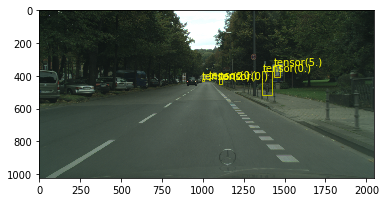

In [58]:
plot_from_image_cityscapes(image,obj_anno)

In [27]:
obj_anno[0]

tensor([[1036.,  413., 1041.,  425.],
        [1101.,  416., 1114.,  447.],
        [1364.,  368., 1425.,  519.],
        [1432.,  331., 1471.,  405.],
        [ 993.,  417., 1004.,  433.]])

In [28]:
xy = (obj_anno[0][0][0],obj_anno[0][0][1])

In [29]:
xy[0],xy[1]

(tensor(1036.), tensor(413.))

In [30]:
width = obj_anno[0][0][0]+obj_anno[0][0][2]
height = obj_anno[0][0][1]+obj_anno[0][0][3]

In [31]:
width,height

(tensor(2077.), tensor(838.))

In [41]:
def plot_from_image_preds(img,total_preds):
    #im = np.array(Image.open(img), dtype=np.uint8)
    fig,ax = plt.subplots(1)
    #ax.imshow(img)
    for i in range(len(total_preds)):
        xy = total_preds[i]['boxes'][0],total_preds[i]['boxes'][1]
        width = total_preds[i]['boxes'][2]-total_preds[i]['boxes'][0]
        height = total_preds[i]['boxes'][3]-total_preds[i]['boxes'][1]
        rect = patches.Rectangle(xy,width,height,linewidth=1,edgecolor='y',facecolor='none')
        ax.text(xy[0],xy[1],classes_inv[total_preds[i]['labels'].item()])
        ax.add_patch(rect)
    ax.imshow(img)

In [26]:
torch.cuda.set_device(2)

In [27]:
model = get_model(6)
#model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

checkpoint = torch.load('saved_models/cityscapes_14.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

In [28]:
with open("datalists/cityscapes_val_images_path.txt", "rb") as fp:
    val_img_paths = pickle.load(fp)
with open("datalists/cityscapes_val_targets_path.txt", "rb") as fp:
    val_anno_paths = pickle.load(fp)

In [29]:
model.eval();

In [47]:
im0 = Image.open(val_img_paths[152])
im0_tensor = torchvision.transforms.ToTensor()(im0);
pred = model([im0_tensor.cuda()])

In [48]:
total_preds = []
for n,confidence in enumerate(pred[0]['scores']):
    if confidence>0.75:
        pred_update = {}
        pred_update['boxes'] = pred[0]['boxes'][n]
        pred_update['labels'] = pred[0]['labels'][n]
        pred_update['scores'] = pred[0]['scores'][n]
        total_preds.append(pred_update)

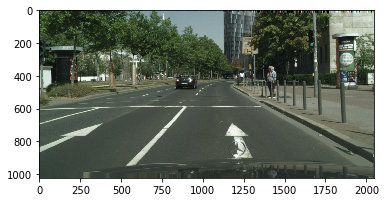

In [49]:
plot_from_image_preds(im0,total_preds)

In [50]:
total_preds

[]